# 📊 GPT-assisted Report Type Classification
This notebook reads PDF reports, extracts front/back pages, and uses OpenAI GPT API to classify the report type and sustainability section presence.

单纯的gpt分类。

In [10]:
from openai import OpenAI
from pathlib import Path
import fitz  # PyMuPDF
import pandas as pd
from tqdm import tqdm
import json
import os
from dotenv import load_dotenv

# Load OpenAI API key from .env file
load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# Paths
PDF_DIR = Path("pdf_folder")  # Ensure this path contains your PDFs
OUTPUT_PATH = Path("results/classify_gpt_results1.csv")

In [11]:
# 重新加载必要模块和OCR补救函数（环境已重置）
from pdf2image import convert_from_path
import pytesseract
from PIL import Image
import tempfile
import os

# OCR 补救函数：用于从首页和末页图像提取文本
def extract_text_with_ocr(pdf_path, front_n=5, back_n=5, dpi=300):
    try:
        with tempfile.TemporaryDirectory() as path:
            # 将 PDF 页转换为图像
            images = convert_from_path(pdf_path, dpi=dpi, output_folder=path)
            total_pages = len(images)
            selected_pages = []

            for i in range(min(front_n, total_pages)):
                selected_pages.append(images[i])

            for i in range(max(0, total_pages - back_n), total_pages):
                selected_pages.append(images[i])

            # 用 OCR 提取文本
            text_parts = [pytesseract.image_to_string(img) for img in selected_pages]
            return "\n".join(text_parts)
    except Exception as e:
        return f"OCR ERROR: {e}"


In [12]:
# Extract front/back page text from a PDF
# def extract_front_back_text(pdf_path, front_n=5, back_n=5):
#     try:
#         doc = fitz.open(pdf_path)
#         texts = []
#         for i in range(min(front_n, len(doc))):
#             texts.append(doc[i].get_text())
#         for i in range(max(0, len(doc) - back_n), len(doc)):
#             texts.append(doc[i].get_text())
#         doc.close()
#         return "\n".join(texts)
#     except Exception as e:
#         return f"ERROR: {e}"
def extract_front_back_text(pdf_path, front_n=5, back_n=5):
    try:
        doc = fitz.open(pdf_path)
        texts = []
        for i in range(min(front_n, len(doc))):
            texts.append(doc[i].get_text())
        for i in range(max(0, len(doc) - back_n), len(doc)):
            texts.append(doc[i].get_text())
        doc.close()
        full_text = "\n".join(texts)
        if len(full_text.strip()) < 50:
            raise ValueError("Empty or invalid text, fallback to OCR.")
        return full_text
    except Exception as e:
        print(f"⚠️ PyMuPDF failed on {pdf_path.name}, switching to OCR...")
        return extract_text_with_ocr(pdf_path)

In [13]:
# Use GPT to classify report type and sustainability section
def classify_report_type(text):
    system_prompt = "You are an expert in classification."
    
    user_prompt = f"""
The following text is extracted from a corporate report (typically the first and last few pages, or a table of contents).

Your tasks:

1. Classify the report into one of the following types:
- "sustainability report": The document primarily focuses on ESG, sustainability, CSR, or GRI/SDGs-related topics. It does NOT contain full audited financial statements.
- "annual report": The document primarily contains audited financial disclosures (e.g., income statement, cash flow statement, balance sheet, auditor’s report). Any ESG content is minimal, scattered, or clearly secondary.
- "integrated report": The document contains BOTH full audited financial disclosures AND a dedicated or structured sustainability section (e.g. a chapter explicitly named “Sustainability”, “ESG”, or “CSR” in the table of contents or headings). ESG content must be substantial and integrated into the structure, not just mentioned briefly.
- "other": The document does not match any of the above categories (e.g., promotional brochures, regulatory filings, environmental statements, etc.)

2. Important judgment rules:
- If the document contains a clear section titled “Sustainability”, “ESG”, “CSR”, “GRI” etc., and this content is more than a few paragraphs, treat it as substantial.
- If BOTH financials and structured sustainability content are found, classify as "integrated report", regardless of the title.
- Do NOT rely solely on the report title (“Annual Report” / “Sustainability Report”) to decide. Always cross-check contents.

3. Also indicate whether a clear sustainability section is present, and extract the section name if available.

Return a JSON object with the following structure:
{{
  "reasoning": "...",
  "report_type": "...",
  "has_sustainability_section": true/false,
  "sustainability_section_name": "..."
}}

Content:
{text}
"""
    
 
# 


    try:
        response = client.chat.completions.create(
            model="gpt-4.1-mini",
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
            temperature=0
        )
        reply = response.choices[0].message.content
        parsed = json.loads(reply)
        return parsed.get("report_type", ""), parsed.get("has_sustainability_section", ""), parsed.get("sustainability_section_name", ""), parsed.get("reasoning", "")
    except Exception as e:
        return "ERROR", "", "", f"Exception: {e}"

In [14]:
# Loop through PDFs and classify
pdf_results = []
for pdf_file in tqdm(os.listdir(PDF_DIR)):
    if not pdf_file.endswith(".pdf"):
        continue
    pdf_path = PDF_DIR / pdf_file
    text = extract_front_back_text(pdf_path)
    if text.startswith("ERROR"):
        pdf_results.append({"filename": pdf_file, "report_type": "ERROR", "has_sustainability_section": ""})
        continue
    report_type, sustainability,sustainability_name,reasoning = classify_report_type(text)
    pdf_results.append({
        "filename": pdf_file,
        "report_type": report_type,
        "has_sustainability_section": sustainability,
        "sustainability_section_name": sustainability_name,
        "reasoning": reasoning
    })

  0%|          | 0/1279 [00:00<?, ?it/s]

 20%|█▉        | 252/1279 [27:21<1:08:03,  3.98s/it]

⚠️ PyMuPDF failed on Unknown_adbi-managing-transition-low-carbon-economy_087is5zy.pdf, switching to OCR...


 20%|██        | 257/1279 [27:41<1:17:52,  4.57s/it]

MuPDF error: format error: cmsOpenProfileFromMem failed

MuPDF error: format error: cmsOpenProfileFromMem failed

MuPDF error: format error: cmsOpenProfileFromMem failed

MuPDF error: format error: cmsOpenProfileFromMem failed



 20%|██        | 258/1279 [27:46<1:17:52,  4.58s/it]

⚠️ PyMuPDF failed on Unknown_2014SustainRpt_FNL_lr_7mrwsfm7.pdf, switching to OCR...


 28%|██▊       | 361/1279 [1:57:43<1:02:34,  4.09s/it]   

⚠️ PyMuPDF failed on Hansae_Yes24_Holdings_Co_Ltd_HANSAE20YES2420HOLDINGS20ESG20REPORT202022_th5kzsfk.pdf, switching to OCR...


 34%|███▎      | 431/1279 [2:02:34<50:56,  3.60s/it]  

⚠️ PyMuPDF failed on Home_Inns__Hotels_Management_Inc_Barclays_Bank_PLC_Annual_Report_202014_5lj1epic.pdf, switching to OCR...


 39%|███▉      | 500/1279 [2:07:38<58:08,  4.48s/it]  

⚠️ PyMuPDF failed on Unknown_adp07-sus-fr_95qx6prh.pdf, switching to OCR...


 53%|█████▎    | 674/1279 [2:21:42<41:58,  4.16s/it]  

⚠️ PyMuPDF failed on Armstrong_Flooring_Inc_SustainabilityReport-2020_kot54emv.pdf, switching to OCR...


 57%|█████▋    | 726/1279 [2:25:45<40:56,  4.44s/it]  

MuPDF error: format error: object is not a stream

MuPDF error: format error: object is not a stream

MuPDF error: format error: object is not a stream

MuPDF error: format error: object is not a stream

MuPDF error: format error: object is not a stream

MuPDF error: format error: object is not a stream

MuPDF error: format error: object is not a stream

MuPDF error: format error: object is not a stream

MuPDF error: format error: object is not a stream

MuPDF error: format error: object is not a stream

MuPDF error: format error: object is not a stream

MuPDF error: format error: object is not a stream

MuPDF error: format error: object is not a stream

MuPDF error: format error: object is not a stream

MuPDF error: format error: object is not a stream

MuPDF error: format error: object is not a stream

MuPDF error: format error: object is not a stream

MuPDF error: format error: object is not a stream

MuPDF error: format error: object is not a stream

MuPDF error: format error: obje

 60%|██████    | 773/1279 [2:29:37<1:07:02,  7.95s/it]

⚠️ PyMuPDF failed on Tam_Jai_International_Co_Ltd_2022083101184_go5rbp4a.pdf, switching to OCR...


 70%|███████   | 898/1279 [2:38:34<21:17,  3.35s/it]  

⚠️ PyMuPDF failed on Hyosung_Corp_SR_2020_en_8g98j6gk.pdf, switching to OCR...


 76%|███████▋  | 976/1279 [2:43:28<16:43,  3.31s/it]

⚠️ PyMuPDF failed on Boryung_Corporation_EBB3B4EBA0B920ECA780EC868DEAB080EB8AA5EAB2BDEC9881EBB3B4EAB3A0EC849CEC9881EBACB8_ebpit5lz.pdf, switching to OCR...


 77%|███████▋  | 989/1279 [2:44:13<16:01,  3.32s/it]

⚠️ PyMuPDF failed on Arvind_Ltd_Arvind_AR_2022-23_0_iwp4673c.pdf, switching to OCR...


 87%|████████▋ | 1108/1279 [3:27:47<16:34,  5.82s/it]    

⚠️ PyMuPDF failed on EKI_Energy_Services_Limited_69298543284_zj7y1tjh.pdf, switching to OCR...


 88%|████████▊ | 1124/1279 [3:28:42<08:25,  3.26s/it]

⚠️ PyMuPDF failed on Unknown_23076_Whitbread_AR2020_web_0v2mxh4f.pdf, switching to OCR...


 90%|████████▉ | 1151/1279 [3:30:23<07:00,  3.28s/it]

MuPDF error: format error: cmsOpenProfileFromMem failed

MuPDF error: format error: cmsOpenProfileFromMem failed

MuPDF error: format error: cmsOpenProfileFromMem failed



 91%|█████████▏| 1170/1279 [3:31:37<06:25,  3.54s/it]

MuPDF error: format error: No default Layer config



 95%|█████████▍| 1211/1279 [3:34:31<04:35,  4.05s/it]

⚠️ PyMuPDF failed on Unknown_2023042101335_kyzhtmjn.pdf, switching to OCR...


 97%|█████████▋| 1241/1279 [3:36:41<04:50,  7.65s/it]

⚠️ PyMuPDF failed on Titan_Company_Ltd_Annual20Report202013_p4r8w07u.pdf, switching to OCR...


 99%|█████████▉| 1271/1279 [3:39:50<00:35,  4.42s/it]

⚠️ PyMuPDF failed on BASF_SE_2012_BASF_Report_lmq79gwn.pdf, switching to OCR...


100%|██████████| 1279/1279 [3:40:26<00:00, 10.34s/it]


In [9]:
# Save results
result_df = pd.DataFrame(pdf_results)
result_df.to_csv(OUTPUT_PATH, index=False)
result_df.head()

,filename,report_type,has_sustainability_section,sustainability_section_name,reasoning
0,Unknown_8f57f855-11bb-496d-9916-91ff88cb537b_s...,ERROR,,,Exception: Error code: 429 - {'error': {'messa...
1,Toyota_Industries_Corp_environment2004_40h96hj...,ERROR,,,Exception: Error code: 429 - {'error': {'messa...
2,Knoll_Inc_Knoll_Enviro_2008_gqetdkb7.pdf,ERROR,,,Exception: Error code: 429 - {'error': {'messa...
3,Intel_Corp__fwws0wtm.pdf,ERROR,,,Exception: Error code: 429 - {'error': {'messa...
4,Unknown_2020_SEBANG20SUSTAINABILITY20REPORT_EN...,ERROR,,,Exception: Error code: 429 - {'error': {'messa...


accuracy pipeline: 86.75%
saved to  classification_comparison_result.xlsx
📊pipeline detailed 

                       precision    recall  f1-score   support

        annual report      0.600     0.545     0.571        11
    integrated report      0.700     0.778     0.737        18
                other      1.000     0.750     0.857         4
sustainability report      0.980     0.980     0.980        50

             accuracy                          0.867        83
            macro avg      0.820     0.763     0.786        83
         weighted avg      0.870     0.867     0.867        83



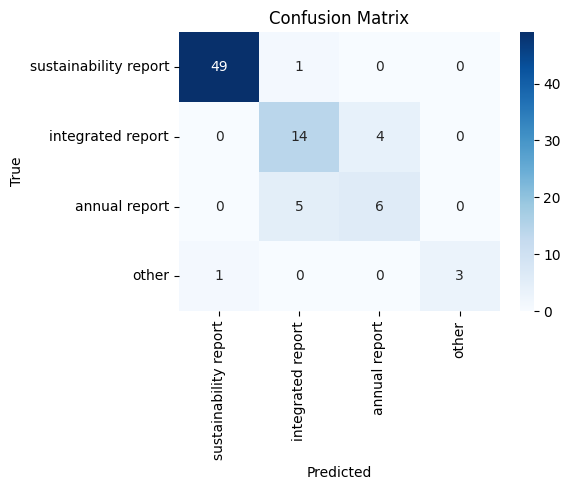

In [8]:
import pandas as pd

# ==== 1. 设置文件路径 ====
# 修改为你本地的绝对路径或相对路径
human_label_path = "check/pdf_classification.xlsx"
gpt_result_path = "output/full_pipeline_results.csv"

# ==== 2. 读取文件 ====
df_human = pd.read_excel(human_label_path)
df_gpt = pd.read_csv(gpt_result_path)

# ==== 3. 标准化列名，确保 filename 和 report_type 存在 ====
df_human.columns = [col.strip().lower() for col in df_human.columns]
df_gpt.columns = [col.strip().lower() for col in df_gpt.columns]

# ==== 4. 合并两个表 ====
df_merged = pd.merge(df_human, df_gpt, left_on="file_name",
    right_on="filename",
    how="left")


# ==== 6. 比较两个分类结果 ====
df_merged["report_type_human"] = df_merged["report_type_human"].str.strip().str.lower()
df_merged["report_type_gpt"] = df_merged["report_type"].str.strip().str.lower()
df_merged["is_correct"] = df_merged["report_type_human"] == df_merged["report_type_gpt"]

# ==== 7. 计算准确率 ====
accuracy = df_merged["is_correct"].mean()
print(f"accuracy pipeline: {accuracy:.2%}")

# ==== 8. 导出对比结果（可选）====
df_merged.to_excel("eval/classification_comparison_pipeline.xlsx", index=False)
print("saved to  classification_comparison_result.xlsx")




import sklearn
from sklearn.metrics import classification_report, confusion_matrix

# === 仅保留非空对比项（防止空值影响）===
valid = df_merged[~df_merged["report_type_human"].isna() & ~df_merged["report_type_gpt"].isna()]

# === 打印 classification report ===
report = classification_report(
    valid["report_type_human"], 
    valid["report_type_gpt"], 
    digits=3, 
    output_dict=False  # 改为 True 可返回字典
)
print("📊pipeline detailed \n")
print(report)

# === 可视化混淆矩阵（可选）===
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(valid["report_type_human"], valid["report_type_gpt"], labels=valid["report_type_human"].unique())
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=valid["report_type_human"].unique(),
            yticklabels=valid["report_type_human"].unique())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

accuracy: 91.57%
saved to classification_comparison_result.xlsx
📊 detailed 

                       precision    recall  f1-score   support

        annual report      0.667     0.909     0.769        11
    integrated report      0.929     0.722     0.812        18
                other      1.000     0.750     0.857         4
sustainability report      0.980     1.000     0.990        50

             accuracy                          0.916        83
            macro avg      0.894     0.845     0.857        83
         weighted avg      0.929     0.916     0.916        83



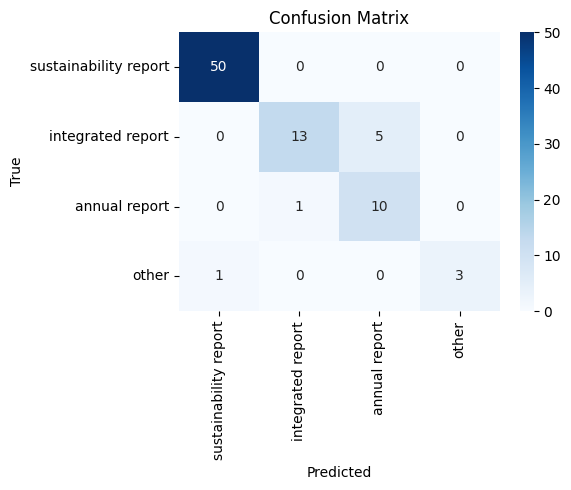

In [1]:
import pandas as pd

# ==== 1. 设置文件路径 ====
# 修改为你本地的绝对路径或相对路径
human_label_path = "check/pdf_classification.xlsx"
gpt_result_path = "output/report_type_gpt_results_new2.csv"

# ==== 2. 读取文件 ====
df_human = pd.read_excel(human_label_path)
df_gpt = pd.read_csv(gpt_result_path)

# ==== 3. 标准化列名，确保 filename 和 report_type 存在 ====
df_human.columns = [col.strip().lower() for col in df_human.columns]
df_gpt.columns = [col.strip().lower() for col in df_gpt.columns]

# ==== 4. 合并两个表 ====
df_merged = pd.merge(df_human, df_gpt, left_on="file_name",
    right_on="filename",
    how="left")


# ==== 6. 比较两个分类结果 ====
df_merged["report_type_human"] = df_merged["report_type_human"].str.strip().str.lower()
df_merged["report_type_gpt"] = df_merged["report_type"].str.strip().str.lower()
df_merged["is_correct"] = df_merged["report_type_human"] == df_merged["report_type_gpt"]

# ==== 7. 计算准确率 ====
accuracy = df_merged["is_correct"].mean()
print(f"accuracy: {accuracy:.2%}")

# ==== 8. 导出对比结果（可选）====
df_merged.to_excel("eval/classification_comparison_single.xlsx", index=False)
print("saved to classification_comparison_result.xlsx")

import sklearn
from sklearn.metrics import classification_report, confusion_matrix

# === 仅保留非空对比项（防止空值影响）===
valid = df_merged[~df_merged["report_type_human"].isna() & ~df_merged["report_type_gpt"].isna()]

# === 打印 classification report ===
report = classification_report(
    valid["report_type_human"], 
    valid["report_type_gpt"], 
    digits=3, 
    output_dict=False  # 改为 True 可返回字典
)
print("📊 detailed \n")
print(report)

# === 可视化混淆矩阵（可选）===
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(valid["report_type_human"], valid["report_type_gpt"], labels=valid["report_type_human"].unique())
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=valid["report_type_human"].unique(),
            yticklabels=valid["report_type_human"].unique())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()